## Import library

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Embedding, BatchNormalization, Dropout, Conv1D
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import os
import re
import matplotlib.pyplot as plt
import string
import nltk
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Get data

In [4]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = "latin", header = None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns = ["sentiment", "id", "data", "query", "user_id", "text"]
df.head()

,sentiment,id,data,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df = df.drop(["id", "data", "query", "user_id"], axis = 1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
df.sentiment = df.sentiment.map({0:"Negative", 4:"Positive"})
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


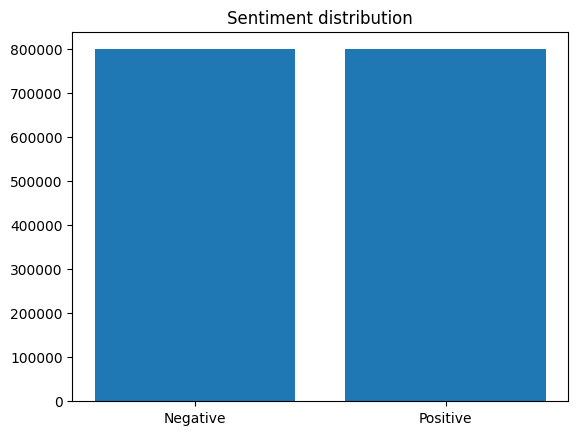

In [8]:
count = df.sentiment.value_counts()
plt.bar(count.index, count)
plt.title("Sentiment distribution")
plt.show()

## Preprocessing

In [9]:
df.sentiment = df.sentiment.map({
    "Positive":1,
    "Negative":0
})
df = df.sample(frac=1)[:int(0.5*len(df))]
df

,sentiment,text
1227189,1,@BuckeyeBrownie noticed ur screenname. r u fro...
173390,0,Burned my pinky. great way to start my weeken...
338358,0,@TAMKIDD i don't know what cynical means
553347,0,@Alys_Marie aw! those poor people I wonder wh...
705236,0,@imTastik needs to let me grow up one day!
...,...,...
1564031,1,she thinks that when she gets bigger and becom...
814780,1,"Maybe Genghis Grill, then 17 Again? Oh, I hope..."
933702,1,My latest video just went live! Show it some l...
372726,0,@DonnieWahlberg oh how I wished I was there!!!...


In [11]:
!unzip -q /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
def preprocessing_text(text):
    #lower text
    text = str(text).lower()
    #remove HTML tag
    text = re.sub("<.*?>","", text)
    #remove URL
    text = re.sub("https?://\S+|www\.\S+","", text)
    #remove punctuation
    text = re.sub(f"[{string.punctuation}]","",text)
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in word_tokenize(text)]
    return " ".join(text)
    

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [12]:
df.text = df.text.apply(preprocessing_text)

In [13]:
df_train, df_temp = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True)
df_val, df_test = train_test_split(df_temp, test_size = 0.5, random_state = 42, shuffle = True)

In [14]:
X_train = df_train.text.to_list()
y_train = df_train.sentiment.to_list()

X_val = df_val.text.to_list()
y_val = df_val.sentiment.to_list()

X_test = df_test.text.to_list()
y_test = df_test.sentiment.to_list()

## Machine Learning Base Model: TF-IDF vectorization and LogisticRegression

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [19]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("lr", LogisticRegression())
])

model_0.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('lr', LogisticRegression())])

In [20]:
#create function to evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def calculate_result(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision = precision_score(y_true, y_pred)
    model_recall = recall_score(y_true, y_pred)
    model_f1 = f1_score(y_true, y_pred)
    result = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    return result

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, normalize = "true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [21]:
model_0_pred = model_0.predict(X_test)
calculate_result(y_test, model_0_pred)

{'accuracy': 0.7971,
 'precision': 0.7920621225194133,
 'recall': 0.8047186114659253,
 'f1': 0.7983402077225066}

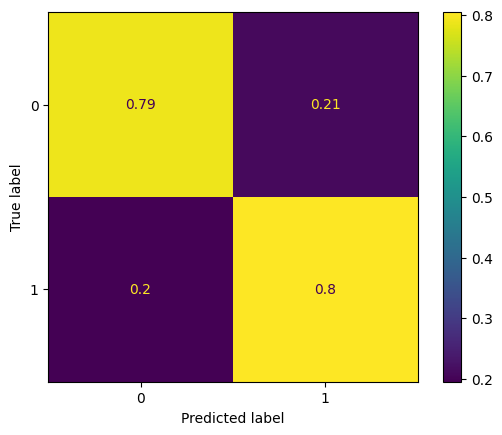

In [22]:
plot_confusion_matrix(y_test, model_0_pred)

## Deep Learning Model: Embedding and LSTM

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [21]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
sentence_length = [len(sentence.split()) for sentence in X_train]
np.percentile(sentence_length, 95)

25.0

In [23]:
text_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=25
)
text_vectorizer.adapt(X_train)

In [24]:
vocab_size = len(text_vectorizer.get_vocabulary())
vocab_size

404142

In [29]:
model_1 = tf.keras.Sequential([
    tf.keras.Input(shape = (1,), dtype = tf.string),
    text_vectorizer,
    Embedding(
        input_dim = vocab_size,
        output_dim = 128
    ),
    Conv1D(64, 5, activation = "relu"),
    Bidirectional(LSTM(
        64, return_sequences = True, recurrent_dropout = 0.2
    )),
    GRU(32),
    Dense(32, activation = "relu"),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation = "sigmoid")
])

model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [30]:
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 25)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 25, 128)             │      51,850,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 21, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 21, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │          15,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,974,593 (198.27 MB)

 Trainable params: 51,974,529 (198.27 MB)

 Non-trainable params: 64 (256.00 B)

In [31]:
mc = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/model1.keras",
    monitor='val_loss',
    verbose=0,
    save_best_only=True
)

rlr = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.1,
    min_lr = 0.00001,
    monitor = 'val_loss',
    verbose = 1,
    min_delta=0.01)
history_1 = model_1.fit(
    train_dataset,
    epochs = 5,
    validation_data = val_dataset,
    callbacks=[mc, rlr]
)

Epoch 1/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1596s 80ms/step - accuracy: 0.7649 - loss: 0.4897 - val_accuracy: 0.8133 - val_loss: 0.4174 - learning_rate: 0.0010
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1590s 80ms/step - accuracy: 0.8693 - loss: 0.3174 - val_accuracy: 0.7993 - val_loss: 0.4711 - learning_rate: 0.0010
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1597s 80ms/step - accuracy: 0.9110 - loss: 0.2249 - val_accuracy: 0.7968 - val_loss: 0.5275 - learning_rate: 0.0010
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1596s 80ms/step - accuracy: 0.9250 - loss: 0.1893 - val_accuracy: 0.8027 - val_loss: 0.5688 - learning_rate: 0.0010
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1568s 78ms/step - accuracy: 0.9367 - loss: 0.1602 - val_accuracy: 0.7970 - val_loss: 0.5964 - learning_rate: 0.0010


In [25]:
def plot_curve(history):
    plt.figure(figsize = (15,5))
    result = pd.DataFrame(history.history)
    plt.subplot(1,2,1)
    plt.plot(result.loss, label = "loss")
    plt.plot(result.val_loss, label = "val_loss")
    plt.xticks(range(5))
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(result.accuracy, label = "accuracy")
    plt.plot(result.val_accuracy, label = "val_accuracy")
    plt.xticks(range(5))
    plt.legend()

In [29]:
plot_curve(history_1)

NameError: name 'history_1' is not defined

In [ ]:
model_1_pred = model_1.predict(test_dataset)
model_1_pred

In [ ]:
calculate_result(y_test, tf.round(model_1_pred))

In [ ]:
plot_confusion_matrix(y_test, tf.round(model_1_pred))

Accuracy is 82%, which is good enough


In [ ]:
import gc

gc.collect()
tf.keras.backend.clear_session()

In [26]:
mc = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/model2.keras",
    monitor='val_loss',
    verbose=0,
    save_best_only=True
)

rlr = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.1,
    min_lr = 0.00001,
    monitor = 'val_loss',
    verbose = 1,
    min_delta=0.01)

model_2 = tf.keras.Sequential([
    tf.keras.Input(shape = (1,), dtype = tf.string),
    text_vectorizer,
    Embedding(
        input_dim = vocab_size,
        output_dim = 128
    ),
    Conv1D(64, 5, activation = "relu"),
    GRU(32),
    Dense(32, activation = "relu"),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation = "sigmoid")
])

model_2.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

history_2 = model_2.fit(
    train_dataset,
    epochs = 5,
    validation_data = val_dataset,
    callbacks=[mc, rlr]
)

Epoch 1/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 665s 33ms/step - accuracy: 0.7449 - loss: 0.5047 - val_accuracy: 0.8150 - val_loss: 0.4026 - learning_rate: 0.0010
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 652s 33ms/step - accuracy: 0.8663 - loss: 0.3240 - val_accuracy: 0.7744 - val_loss: 0.5291 - learning_rate: 0.0010
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 652s 33ms/step - accuracy: 0.9109 - loss: 0.2273 - val_accuracy: 0.7815 - val_loss: 0.5558 - learning_rate: 0.0010
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 652s 33ms/step - accuracy: 0.9263 - loss: 0.1887 - val_accuracy: 0.7707 - val_loss: 0.6320 - learning_rate: 0.0010
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 653s 33ms/step - accuracy: 0.9381 - loss: 0.1603 - val_accuracy: 0.7869 - val_loss: 0.6385 - learning_rate: 0.0010


In [29]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/model2.keras')

/kaggle/working/model2.keras